In [ ]:
pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3 MB 18.2 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
import yfinance as yf
ETH =  yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "ETH-USD",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "max"

    )
ETH

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,164329
2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188
2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170
2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283
2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100
...,...,...,...,...,...,...
2021-11-26,4522.208984,4550.842285,3933.506592,4030.908936,4030.908936,26281795488
2021-11-27,4042.999023,4187.684082,4033.513916,4096.912109,4096.912109,16515693874
2021-11-28,4101.648926,4297.916504,3989.969971,4294.453613,4294.453613,15953126340


In [ ]:
ETH['ret'] = ETH.Close/ETH.Close.shift(1)-1
ETH_ret = ETH[["ret"]].fillna(0)
ETH_ret = ETH[['ret']]
ETH_ret = ETH_ret.shift(-1)
ETH_ret

,ret
Date,
2015-08-07,-0.728250
2015-08-08,-0.068268
2015-08-09,0.009333
2015-08-10,0.507323
2015-08-11,0.140075
...,...
2021-11-26,0.016374
2021-11-27,0.048217
2021-11-28,0.035080


In [ ]:
from google.colab import files
ETH = files.upload()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import io
import pandas as pd
ETH_total = pd.read_csv(io.BytesIO(ETH['BTC_total.csv']))

In [ ]:
## Merge vectors and ret of ETH

#decompose using PCA
from sklearn.decomposition import PCA
#pca components k
k = 20

pca_model = PCA(n_components=k,random_state=0)
reduced_X = pca_model.fit_transform(ETH_total)
topic_vectors_reduced = pd.DataFrame(reduced_X, index = ETH_total.index)

ETH_final = topic_vectors_reduced.join(ETH_ret, how="left").dropna()
ETH_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,ret
2015-08-07,-0.400091,0.360309,0.326650,-0.575662,-0.227988,-0.324846,-0.322314,-0.081054,-0.134044,-0.305117,-0.213023,0.113855,0.120540,0.142838,-0.047680,-0.593707,0.165644,0.271256,0.300218,-0.362383,-0.728250
2015-08-08,-0.767091,-0.382686,0.139420,0.129595,0.131329,-0.048404,-0.243959,-0.050150,0.486032,0.076700,-0.143249,-0.515927,0.229079,-0.018437,-0.116906,-0.114368,-0.070894,-0.167385,-0.142033,0.173071,-0.068268
2015-08-09,0.204294,0.335474,0.174738,0.801999,0.077635,-0.180631,-0.240809,0.067531,0.194729,0.022138,-0.193680,0.465021,-0.065694,-0.233249,0.276689,0.434445,-0.051769,0.114680,-0.214130,0.474329,0.009333
2015-08-10,0.948408,-0.058605,0.000122,-0.193144,-0.407845,0.157489,0.098248,0.610623,-0.154490,0.052278,-0.432803,-0.312658,0.153837,0.245123,-0.310280,-0.394415,-0.237507,-0.176660,-0.213744,-0.091981,0.507323
2015-08-11,-0.347532,0.294041,0.682745,-0.591012,-0.318973,-0.109869,-0.245589,0.455383,0.122854,0.398525,-0.353938,-0.162458,-0.552056,0.117027,0.162647,-0.240689,0.087231,0.012823,-0.346032,-0.403287,0.140075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-27,0.302118,1.066356,-0.030191,0.362687,0.461102,-0.330098,0.437094,-0.119854,0.020355,-0.232540,0.116001,0.141768,0.194781,0.193276,-0.095421,-0.096177,-0.193582,0.134712,-0.047012,-0.053804,0.090849
2021-10-28,-0.835460,-0.366577,0.447555,-0.093929,0.253136,-0.072920,-0.305479,-0.108034,0.329025,0.260630,-0.432908,-0.039528,0.181794,-0.044961,-0.065589,-0.463474,0.059518,-0.033127,0.351504,-0.284582,0.029722
2021-10-29,0.048632,-0.589579,0.213141,-0.013560,0.174988,-0.188523,-0.222654,0.028967,-0.062880,0.102752,0.280906,-0.400120,-0.141278,0.200614,0.130773,0.129089,0.071741,0.222164,-0.012778,0.154990,-0.020181
2021-10-30,0.179621,-0.268775,0.100545,-0.091363,0.742275,0.319818,-0.000166,-0.420521,0.658968,0.017176,0.127931,0.143467,0.287907,0.056286,0.344018,-0.102220,0.254976,-0.199395,0.099958,0.132361,-0.008687


In [ ]:
## Train, test data
ETH_train = ETH_final[(ETH_final.index >= '2015-08-07') & (ETH_final.index <= '2020-12-31')]
ETH_test = ETH_final[(ETH_final.index >= '2021-01-01')]
X_train, Y_train = ETH_train.iloc[:,:-1], ETH_train.iloc[:,-1]
X_test, Y_test = ETH_test.iloc[:,:-1], ETH_test.iloc[:,-1]

>1 0.507 (0.025)
>2 0.498 (0.032)
>3 0.496 (0.037)
>4 0.496 (0.041)
>5 0.505 (0.030)
>6 0.496 (0.038)
>7 0.501 (0.029)


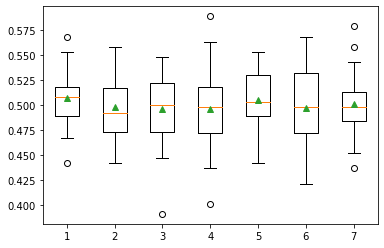

In [ ]:
# explore random forest number of features effect on performance
import numpy as np
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
 
# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 1 to 7
	for i in range(1,8):
		models[str(i)] = RandomForestClassifier(max_features=i)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
X, y = X_train, np.sign(Y_train)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>10 0.498 (0.038)
>50 0.493 (0.036)
>100 0.503 (0.030)
>500 0.506 (0.039)
>1000 0.502 (0.031)


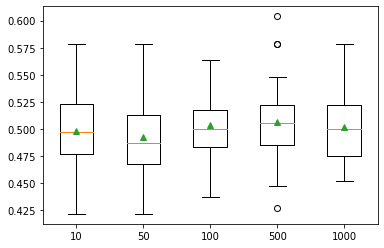

In [ ]:
def get_models_n_trees():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000]
	for n in n_trees:
		models[str(n)] = RandomForestClassifier(n_estimators=n)
	return models
 
# define dataset
X, y = X_train, np.sign(Y_train)
# get the models to evaluate
models = get_models_n_trees()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>1 0.492 (0.031)
>2 0.495 (0.038)
>3 0.499 (0.037)
>4 0.494 (0.032)
>5 0.493 (0.029)
>6 0.496 (0.020)
>7 0.506 (0.034)
>None 0.498 (0.031)


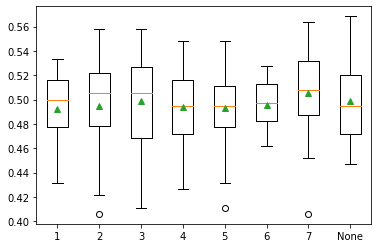

In [ ]:
def get_models_max_depth():
	models = dict()
	# consider tree depths from 1 to 7 and None=full
	depths = [i for i in range(1,8)] + [None]
	for n in depths:
		models[str(n)] = RandomForestClassifier(max_depth=n)
	return models

# define dataset
X, y = X_train, np.sign(Y_train)
# get the models to evaluate
models = get_models_max_depth()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
## After tuning hyperparameter, we choose max_feateres=1, n_estimators=100

model = RandomForestClassifier(max_features=1, n_estimators=100, max_depth=7)
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, np.sign(Y_train), scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

model.fit(X_train, np.sign(Y_train))
Y_predict = model.predict(X_test)

Accuracy: 0.494 (0.034)


In [ ]:
test = model.predict(X_test)>0

In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(np.sign(Y_test), Y_predict)

array([[ 50,  83],
       [ 62, 109]])

In [ ]:
def score_model(true, pred, columns = ""):
    cm = confusion_matrix(true,pred)
    l = np.sum(cm)
    cm = cm/l
    s = [accuracy_score(true, pred), matthews_corrcoef(true, pred), f1_score(true,pred), cm[0,0], cm[1,1],cm[0,1],cm[1,0]]
    return pd.DataFrame(data = s, index = ['accuracy', 'matthew_corr', 'f1', 'tn', 'tp','fp','fn'], columns = [columns])

In [ ]:
score_model(np.sign(Y_test), Y_predict, columns = "ETH_RandomForest")

,ETH_RandomForest
accuracy,0.523026
matthew_corr,0.013746
f1,0.600551
tn,0.164474
tp,0.358553
fp,0.273026
fn,0.203947


>10 0.519 (0.039)
>50 0.507 (0.042)
>100 0.507 (0.042)
>500 0.508 (0.033)
>1000 0.509 (0.033)
>5000 0.513 (0.032)


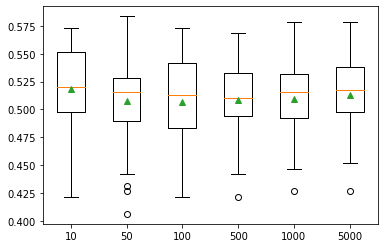

In [ ]:
## Boosting Method

# explore xgboost random forest number of trees effect on performance
from xgboost import XGBRFClassifier

# get a list of models to evaluate
def get_models_n_trees_boost():
	models = dict()
	# define the number of trees to consider
	n_trees = [10, 50, 100, 500, 1000, 5000]
	for v in n_trees:
		models[str(v)] = XGBRFClassifier(n_estimators=v, subsample=0.9, colsample_bynode=0.2)
	return models


# define dataset
X, y = X_train, np.sign(Y_train)
# get the models to evaluate
models = get_models_n_trees_boost()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the results
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>0.1 0.499 (0.032)
>0.2 0.507 (0.042)
>0.3 0.507 (0.038)
>0.4 0.505 (0.034)
>0.5 0.509 (0.033)
>0.6 0.511 (0.031)
>0.7 0.508 (0.029)
>0.8 0.509 (0.030)
>0.9 0.510 (0.031)
>1.0 0.509 (0.033)


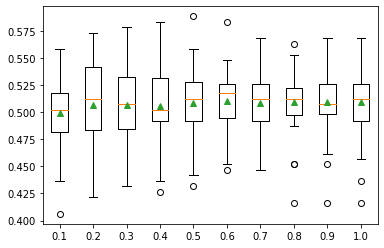

In [ ]:
from numpy import arange
def get_models_features_boost():
	models = dict()
	for v in arange(0.1, 1.1, 0.1):
		key = '%.1f' % v
		models[key] = XGBRFClassifier(n_estimators=100, subsample=0.9, colsample_bynode=v)
	return models

# define dataset
X, y = X_train, np.sign(Y_train)
# get the models to evaluate
models = get_models_features_boost()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the results
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
## After tuning hyperparameter, we choose n_estimators=500, colsample_bynode=0.6
model_boost = XGBRFClassifier(n_estimators=500, subsample=0.9, colsample_bynode=0.6)
# fit the model on the whole dataset
model_boost.fit(X_train, np.sign(Y_train))
# make a prediction
Y_predict_boost = model_boost.predict(X_test)

In [ ]:
confusion_matrix(np.sign(Y_test), Y_predict_boost)

array([[74, 59],
       [95, 76]])

In [ ]:
score_model(np.sign(Y_test), Y_predict_boost, columns = "ETH_Boosting")

,ETH_Boosting
accuracy,0.493421
matthew_corr,0.000834
f1,0.496732
tn,0.243421
tp,0.250000
fp,0.194079
fn,0.312500
